# Reformatting Ubuntu Dialogue Corpus for Chatbot Model

## Dataset Description

**How to run this notebook**: 
1. Download the data from the [github repository](https://github.com/rkadlec/ubuntu-ranking-dataset-creator)
2. CD to the downloaded directory and run ```./generate.sh -t -l```. I downloaded 1 mill. train samples with p = 1.0. 
3. Change the value of DATA_DIR below to your project path root.

I chose to copy the first 10k lines of data into a "sample" directory so I could quickly play around with the data, and then use the full dataset when done.

Random facts [from paper](https://arxiv.org/abs/1506.08909):
* 2-way (dyadic) conversation, as opposed to multi-participant.


## Load the Data

In [7]:
import numpy as np
import os.path
import pdb
import pandas as pd
from pprint import pprint

#DATA_DIR = '/home/brandon/terabyte/Datasets/ubuntu_dialogue_corpus/'
DATA_DIR = '/home/brandon/ubuntu_dialogue_corpus/src/' # sample/'
TRAIN_PATH = DATA_DIR + 'train.csv'
VALID_PATH = DATA_DIR + 'valid.csv'
TEST_PATH = DATA_DIR + 'test.csv'

def get_training():
    """Returns dataframe data from train.csv """
    # First, we need to load the data directly into a dataframe from the train.csv file. 
    df_train = pd.read_csv(TRAIN_PATH)
    # Remove all examples with label = 0. (why would i want to train on false examples?)
    df_train = df_train.loc[df_train['Label'] == 1.0]
    # Don't care about the pandas indices in the df, so remove them.
    df_train = df_train.reset_index(drop=True)
    df_train = df_train[df_train.columns[:2]]
    return df_train

def get_validation():
    """Returns data from valid.csv """
    # First, we need to load the data directly into a dataframe from the train.csv file. 
    df_valid = pd.read_csv(VALID_PATH)
    first_two_cols = df_valid.columns[:2]
    df_valid = df_valid[first_two_cols]
    df_valid.columns = ['Context', 'Utterance']
    return df_valid

df_train = get_training()
df_valid = get_validation()

## Functions for Visualization and Reformatting

In [8]:
# Now get all of the data in a single string and make a 'vocabulary' (unique words). 
import nltk, re, pprint
from nltk import word_tokenize
import pdb

def print_single_turn(turn: str):
    as_list_of_utters = turn.split('__eou__')[:-1]
    for idx_utter, utter in enumerate(as_list_of_utters):
        print("\t>>>", utter)

def print_conversation(df, index=0):
    """Display the ith conversation in nice format."""
    
    # Get the row identified by 'index'. 
    context_entry = df['Context'].values[index]
    target        = df['Utterance'].values[index]
    
    # Split returns a blank last entry, so don't store.
    turns = context_entry.split('__eot__')[:-1]
    print('--------------------- CONTEXT ------------------- ')
    for idx_turn, turn in enumerate(turns):
        print("\nUser {}: ".format(idx_turn % 2))
        print_single_turn(turn)
    print('\n--------------------- RESPONSE ------------------- ')
    print("\nUser {}: ".format(len(turns) % 2))
    print_single_turn(target)
        
def get_user_arrays(df):
    """Returns two arrays of every other turn. 
    Specifically:
        len(returned array) is number of rows in df.  I SURE HOPE NOT!
        each entry is a numpy array. 
        each numpy array contains utterances as entries. 
    """
    userOne = []
    userTwo = []
    contexts = df['Context'].values
    targets  = df['Utterance'].values
    assert(len(contexts) == len(targets))
    
    for i in range(len(contexts)):
        # combined SINGLE CONVERSATION ENTRY of multiple turns each with multiple utterances.
        list_of_turns = contexts[i].lower().split('__eot__')[:-1] + [targets[i].lower()]
        # make sure even number of entries
        if len(list_of_turns) % 2 != 0:
            list_of_turns = list_of_turns[:-1]
        # strip out the __eou__ occurences (leading space bc otherwise would result in two spaces)
        new_list_of_turns = []
        for turn in list_of_turns:
            utter_list = turn.lower().split(" __eou__")
            #if len(utter_list) > 3:
            #   utter_list = utter_list[:3]
            new_list_of_turns.append("".join(utter_list))
        #list_of_turns = [re.sub(' __eou__', '', t) for t in list_of_turns]
        userOneThisConvo = new_list_of_turns[0::2]
        userTwoThisConvo = new_list_of_turns[1::2]
        userOne += userOneThisConvo 
        userTwo += userTwoThisConvo
    assert(len(userOne) == len(userTwo))
    return userOne, userTwo

def save_to_file(fname, arr):
    with open(DATA_DIR+fname,"w") as f:
        for line in arr:
            f.write(line + "\n")

## Training Data

#### At a Glance

In [4]:
df_train.describe()

,Context,Utterance
count,1000000,1000000
unique,957096,849957
top,! ops __eou__ __eot__ ? __eou__ __eot__,thank __eou__
freq,14,11658


In [5]:
pd.options.display.max_colwidth = 500
df_train.head(2)

,Context,Utterance
0,"i think we could import the old comment via rsync , but from there we need to go via email . I think it be easier than cache the status on each bug and than import bits here and there __eou__ __eot__ it would be very easy to keep a hash db of message-ids __eou__ sound good __eou__ __eot__ ok __eou__ perhaps we can ship an ad-hoc apt_prefereces __eou__ __eot__ version ? __eou__ __eot__ thank __eou__ __eot__ not yet __eou__ it be cover by your insurance ? __eou__ __eot__ yes __eou__ but it 's ...",basically each xfree86 upload will NOT force users to upgrade 100Mb of fonts for nothing __eou__ no something i do in my spare time . __eou__
1,"I 'm not suggest all - only the ones you modify . __eou__ __eot__ ok , it sound like you 're agree with me , then __eou__ though rather than `` the ones we modify '' , my idea be `` the ones we need to merge '' __eou__ __eot__",oh ? oops . __eou__


In [6]:
print_conversation(df_train, 3)

--------------------- CONTEXT ------------------- 

User 0: 
	>>> interest 
	>>>  grub-install work with / be ext3 , fail when it be xfs 
	>>>  i think d-i instal the relevant kernel for your machine . i have a p4 and its instal the 386 kernel 
	>>>  holy crap a lot of stuff get instal by default : ) 
	>>>  YOU ARE INSTALLING VIM ON A BOX OF MINE 
	>>>  ; ) 

User 1: 
	>>>  more like osx than debian ; ) 
	>>>  we have a selection of python modules available for great justice ( and python development ) 

User 0: 
	>>>  2.8 be fix them iirc 

User 1: 
	>>>  pong 
	>>>  vino will be in 
	>>>  enjoy ubuntu ? 

User 0: 
	>>>  tell me to come here 
	>>>  suggest thursday as a good day to come 

User 1: 
	>>>  we freeze versions a while back : ) 
	>>>  you come today or thursday ? 
	>>>  we 're consider shift it 
	>>>  yay 
	>>>  enjoy ubuntu ? 
	>>>  usplash ! 

User 0: 
	>>>  thats the one 

User 1: 
	>>>  so i saw your email with the mockup at the airport , but it have n't appear now that 

#### Turn-Based DataFrame

In [10]:
#df_merged = pd.DataFrame(df_train['Context'].map(str) + df_train['Utterance'])
userOne, userTwo = get_user_arrays(df_train)
df_turns = pd.DataFrame({'UserOne': userOne, 'UserTwo': userTwo})
df_turns.head(200)

,UserOne,UserTwo
0,i think we could import the old comment via rs...,it would be very easy to keep a hash db of me...
1,ok perhaps we can ship an ad-hoc apt_prefereces,version ?
2,thank,not yet it be cover by your insurance ?
3,yes but it 's really not the right time : / w...,you will be move into your house soon ? post ...
4,how urgent be # 896 ?,"not particularly urgent , but a policy violat..."
5,i agree that we should kill the -novtswitch,ok
6,would you consider a package split a feature ?,context ?
7,split xfonts* out of xfree86* . one upload fo...,split the source package you mean ?
8,yes . same binary package .,i would prefer to avoid it at this stage . th...
9,i 'm not suggest all - only the ones you modif...,"ok , it sound like you 're agree with me , th..."


#### Sentence-Based DataFrame

In [5]:
userOne[0]

'i think we could import the old comment via rsync , but from there we need to go via email . I think it be easier than cache the status on each bug and than import bits here and there '

In [6]:

def get_sentences(userOne, userTwo):
    encoder = []
    decoder = []
    assert(len(userOne) == len(userTwo))
    for i in range(len(userOne)):
        one = nltk.sent_tokenize(userOne[i])
        one = [s for s in one if s != '.']
        two = nltk.sent_tokenize(userTwo[i])
        two = [s for s in two if s != '.']
        combine = one + two
        assert(len(combine) == len(one) + len(two))
        if len(combine) % 2 != 0:
            combine = combine[:-1]
        enc = combine[0::2]
        dec = combine[1::2]
        assert(len(enc) == len(dec))
        encoder.append(enc)
        decoder.append(dec)
    return encoder, decoder
encoder, decoder = get_sentences(userOne, userTwo)
print('done')

KeyboardInterrupt: 

In [ ]:
encoder = [nltk.word_tokenize(s[0]) for s in encoder]
decoder = [nltk.word_tokenize(s[0]) for s in decoder]

In [ ]:
max_enc_len = max([len(s) for s in encoder])
max_dec_len = max([len(s) for s in decoder])
print(max_enc_len)
print(max_dec_len)

#### Analyzing Sentence Lengths

In [ ]:
encoder_lengths = [len(s) for s in encoder]
decoder_lengths = [len(s) for s in decoder]
df_lengths = pd.DataFrame({'EncoderSentLength': encoder_lengths, 'DecoderSentLengths': decoder_lengths})
df_lengths.describe()

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 9, 5
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplot(1, 2, 1)
plt.hist(encoder_lengths)
plt.subplot(1, 2, 2)
plt.hist(decoder_lengths, color='b')
plt.tight_layout()
plt.show()

In [11]:
save_to_file("train_from.txt", userOne)
save_to_file("train_to.txt", userTwo)

### Validation Data

In [12]:
print("df_valid has", len(df_valid), "rows.")
df_valid.head()

df_valid has 19560 rows.


,Context,Utterance
0,Any ideas on how lts will be release ? __eou__...,We be talk 12.04 not 10.04 __eou__
1,how much hdd use ubuntu default install ? __eo...,thats why i ask how much be default install ? ...
2,in my country its nearly the 27th __eou__ when...,thanx __eou__
3,it 's not out __eou__ __eot__ they probabaly b...,wait for many things to be setup __eou__ final...
4,be the ext4 drivers stable ? __eou__ __eot__ I...,you sound like it 's update to skynet . ; ) __...


In [13]:
userOne, userTwo = get_user_arrays(df_valid)
save_to_file("valid_from.txt", userOne)
save_to_file("valid_to.txt", userTwo)

In [14]:
print('done')

done


# Visualization

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
userOne, userTwo = get_user_arrays(df_train)
# Regular expressions used to tokenize.
_WORD_SPLIT = re.compile(b"([.,!?\"':;)(])")
_DIGIT_RE   = re.compile(br"\d")
lengths = np.array([len(t.strip().split()) for t in userOne])

max_ind =  lengths.argmax()
print(max(lengths), "at", max_ind)
print("Sentence:\n", userOne[max_ind])

855 at 1330067
Sentence:
  thanks : ) i know , it use .deb , but read my word , they say that nothing like .deb or source be there . that be know to me , so iam think of use alien to build the deb i have see the entire internet , and even the sdl developers tell me , that they do n't exist . lol , what be you say ? there be no .deb yet for wesnoth 1.8 , also , i know i need to compile it , but the source be not available for sdl11-config , i instal them all , no result yes , the older ones be available . sorry , but make the previous version be different . the previous versions of wesnoth do not need all sdl libraries , lol , thank , but that be for wesnoth 1.6.1 , at least 2 years older , but i say 1.8 , anyway . thanks for the help . i be search for a source , and let me compile it . lol , still a formidable game can be make , against age of empires series , : d penumbra if commercial , but o a.d be not , : d a demo be not open-source , and also , the what i like be a rts , like the 

(array([  1.85629000e+06,   2.48062000e+05,   4.06420000e+04,
          8.01600000e+03,   2.06200000e+03,   6.29000000e+02,
          1.99000000e+02,   8.00000000e+01,   3.90000000e+01,
          1.50000000e+01]),
 array([   0. ,   39.3,   78.6,  117.9,  157.2,  196.5,  235.8,  275.1,
         314.4,  353.7,  393. ]),
 <a list of 10 Patch objects>)

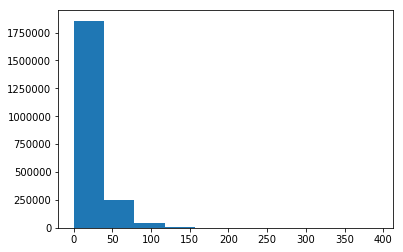

In [19]:
import matplotlib.pyplot as plt
plt.hist(sorted(lengths)[:-20])

In [20]:
n_under_20 = sum([1 if l < 100 else 0 for l in lengths])
print(n_under_20, "out of", len(lengths), "({}\%)".format(float(n_under_20)/len(lengths)))

2134602 out of 2156054 (0.9900503419673162\%)


In [21]:
df_lengths = pd.DataFrame(lengths)

In [22]:
df_lengths.describe()

,0
count,2.156054e+06
mean,2.171190e+01
std,2.074356e+01
min,0.000000e+00
25%,8.000000e+00
50%,1.600000e+01
75%,2.800000e+01
max,8.550000e+02


## Relationship between Accuracy, Loss, and Others

$$
\text{Loss} = - \frac{1}{N} \sum_{i = 1}^{N} \ln\left(p_{target_i}\right)
$$

Loss for uniformly random guessing is 10.5966347331


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


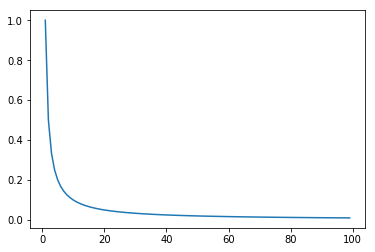

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Number of gradient descent steps, each over a batch_size amount of data.
vocab_size = 40000

# Uniform chance of guessing any word. 
loss_random_guess = np.log(float(vocab_size))
print("Loss for uniformly random guessing is", loss_random_guess)

sent_length = [5, 10, 25]
# Outputs correct target x percent of the time. 
pred_accuracy = np.arange(100)

plt.plot(pred_accuracy, [1./p for p in pred_accuracy])

99


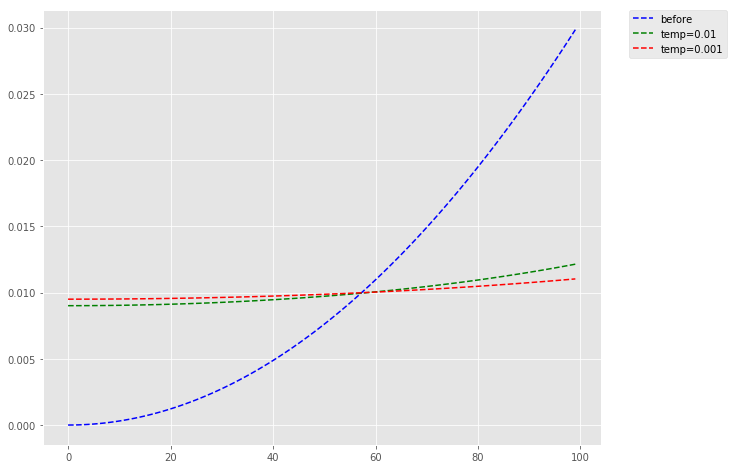

In [27]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 8
def _sample(logits, t):
    res = logits / t
    res = np.exp(res) / np.sum(np.exp(res))
    return res

N = 100
x = np.arange(N)
before = np.array([1.0+i**2 for i in range(N)])
before /= before.sum()

plt.plot(x, before, 'b--', label='before')

after = _sample(before, 0.1)
plt.plot(x, after, 'g--', label='temp=0.01')

after = _sample(before, 0.2)
print(after.argmax())
plt.plot(x, after, 'r--', label='temp=0.001')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [5]:
np.info(plt.plot)

 plot(*args, **kwargs)

Plot lines and/or markers to the
:class:`~matplotlib.axes.Axes`.  *args* is a variable length
argument, allowing for multiple *x*, *y* pairs with an
optional format string.  For example, each of the following is
legal::

    plot(x, y)        # plot x and y using default line style and color
    plot(x, y, 'bo')  # plot x and y using blue circle markers
    plot(y)           # plot y using x as index array 0..N-1
    plot(y, 'r+')     # ditto, but with red plusses

If *x* and/or *y* is 2-dimensional, then the corresponding columns
will be plotted.

If used with labeled data, make sure that the color spec is not
included as an element in data, as otherwise the last case
``plot("v","r", data={"v":..., "r":...)``
can be interpreted as the first case which would do ``plot(v, r)``
using the default line style and color.

If not used with labeled data (i.e., without a data argument),
an arbitrary number of *x*, *y*, *fmt* groups can be specified, as in::

    a.plot(x